# An End-to-End Project on Time Series Analysis and Forecasting with Python

**A time series is a series of data points indexed (or listed or graphed) in time order.**

Most commonly, a time series is a sequence taken at successive equally spaced points in time. Thus it is a sequence of discrete-time data

Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. Time series forecasting is the use of a model to predict future values based on previously observed values.

**Time series are widely used for non-stationary data, like economic, weather, stock price, and retail sales in this post.** We will demonstrate different approaches for forecasting retail sales time series. Let’s get started!

# The Data

We are using Superstore sales data.

In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

#fontsize of the x any y labels(axes.labelsize)
matplotlib.rcParams['axes.labelsize'] =14
#fontsize of the tick labels
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
%matplotlib inline


    Matplotlib uses matplotlibrc configuration files to customize all kinds of properties, which we call rc settings or rc parameters. You can control the defaults of almost every property in matplotlib: figure size and dpi, line width, color and style, axes, axis and grid properties, text and font properties and so on

In [3]:
df = pd.read_excel('Superstore.xls')

In [4]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


There are several categories in the Superstore sales data, we start from time series analysis and forecasting for furniture sales.

In [5]:
furniture = df.loc[df['Category']== 'Furniture']

We have a good 4-year furniture sales data.

In [6]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

# Data Preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [8]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 
        'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 
        'Sub-Category', 'Product Name', 'Quantity','Discount', 'Profit']

In [9]:
furniture.drop(cols, axis=1, inplace=True)

In [10]:
furniture.head(10)

,Order Date,Sales
0,2016-11-08,261.9600
1,2016-11-08,731.9400
3,2015-10-11,957.5775
5,2014-06-09,48.8600
10,2014-06-09,1706.1840
23,2017-07-16,71.3720
24,2015-09-25,1044.6300
27,2015-09-17,3083.4300
29,2015-09-17,124.2000
36,2016-12-08,190.9200


In [11]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [12]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

# Indexing with Time Series Data

In [13]:
#Set the DataFrame index using existing columns.
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Our current datetime data can be tricky to work with, therefore, **we will use the averages daily sales value for that month instead,** and we are using the start of each month as the timestamp.

**Resampling is the method that consists of drawing repeated samples from the original data samples.** The method of Resampling is a nonparametric method of statistical inference. ...

In [14]:
#Resample time-series data.
#Convenience method for frequency conversion and resampling of time series. Object must have a datetime-like index 
#MS~month start frequency
#weekly datacan be tricky to work with since it's briefer amt of time, so let's use 
#monthly averages instead.
#We'll make the conversion with the resample function
y = furniture['Sales'].resample('MS').mean()

Have a quick peek 2017 furniture sales data.

In [15]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

# Visualizing Furniture Sales Time Series Data

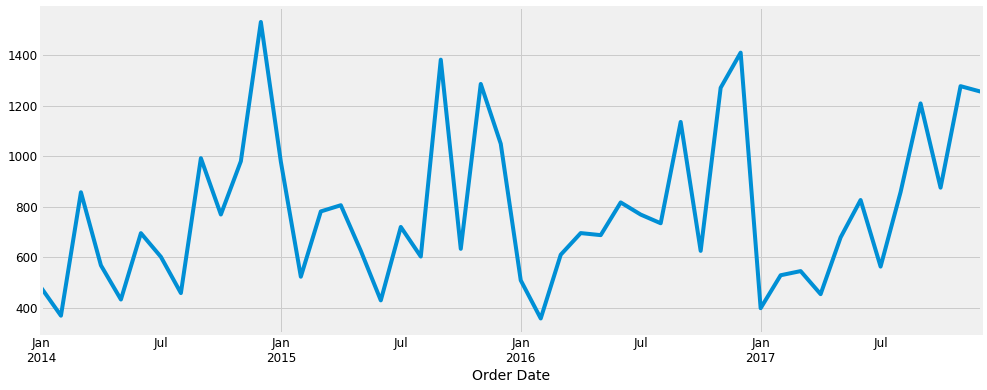

In [16]:
y.plot(figsize=(15, 6))

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called **time-series decomposition** that allows us to decompose our time series into three distinct components: **trend, seasonality, and noise.**

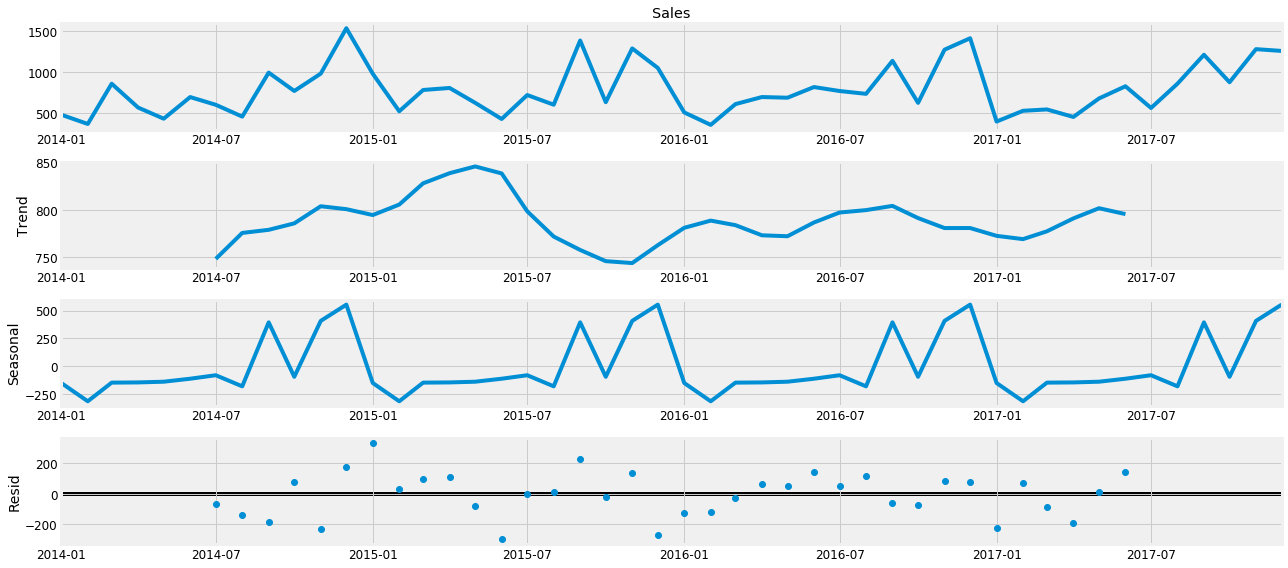

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 18,8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()

**The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.**

# Time series forecasting with ARIMA

One of the most common metods used in time series forecasting is known as the ARIMA model, which stands for **Autoregressive Integrated Moving Averages**.ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.


There are three distinct integers (p,d,q) that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation ARIMA(p,d,q). **Together these three parameters account for seasonality, trend, and noise in datasets:**

    1.**p is the auto-regressive part of the model.** It allows us to incorporate the effect of past values into our model.  Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
    
    2. **d is the integrated part of the model.** This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
    
    3. **q is the moving average part of the model.** This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
    




When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

The seasonal ARIMA method can appear daunting because of the multiple tuning parameters involved. **In the next section, we will describe how to automate the process of identifying the optimal set of parameters for the seasonal ARIMA time series model.**

# Parameter Selection for the ARIMA Time Series Model

When looking to fit time series data with a seasonal ARIMA model, our first goal is to find the values of ARIMA(p,d,q)(P,D,Q)s that optimize a metric of interest. There are many guideline and best practices to achieve this goal, yet the correct parametrization of ARIMA models can be a painstaking manual process that require domain expertise and time. Other statistical programming language such as R provide automated ways to solve this issue, but those have yet to be ported over to Python. In this section, we will resolve this issue by writing Python code to programmatically select the optimal parameter values for our ARIMA(p,d,q)(P,D,Q)s time series model.


**We will use a "grid search" to iteratively explore different combinations of parameters.** For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX( ) function from the statsmodels module and assess its overall quality.

Once we have explored the entire landscape of parameters, **our optimal set of parameters will be the one that yields the best performance for our criteria of interest.** Let's begin by generating the various combinations of parameters that we wish to assess.

In [18]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
#Generate all different combinations of p,d and q triplets
pdq = list(itertools.product(p, d, q))

#Generate all different combinations of seasonal p,d,q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We can now use the triplets of parameters defined above to automate the process of training and evaluating ARIMA models on different combinations.

**In statistics and Machine Learning, this process is known as grid search (or hyperparameter optimization) for model selection**

When evaluating and comparing statistical models fitted with different parameter, each can be ranked against one another based  on how well it fits the data or its ability to accurately predict future data points.

**We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model.**



A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. **Therefore, we are interested in finding the model that yields the lowest AIC value**

The code chunk below iterates through combinations of parameters and uses the SARIMAX function from statsmodels to fit the corresponding Seasonal ARIMA model. Here, the order argument specifies the (p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal component of the Seasonal ARIMA model. After fitting each SARIMAX()model, the code prints out its respective AIC score.

**This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.**

Because some parameter combinations may lead to numerical misspecifications, **we explicitly disabled warning messages in order to avoid an overload of warning messages.** These misspecifications can also lead to errors and throw an exception, so we make sure to catch these exceptions and ignore the parameter combinations that cause these issues.

In [19]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order=param,seasonal_order=param_seasonal,enforce_stationary=False,enforce_invertibility=False)
            results = mod.fit()
            
            print('ARIMA{}*{}12 - AIC:{}'.format(param,
                                                 param_seasonal,results.aic))
        except:
            continue

ARIMA(0, 0, 0)*(0, 0, 0, 12)12 - AIC:784.7193402038779


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)*(0, 0, 1, 12)12 - AIC:2015.9577534067455
ARIMA(0, 0, 0)*(0, 1, 0, 12)12 - AIC:495.3709027487691
ARIMA(0, 0, 0)*(0, 1, 1, 12)12 - AIC:489.83053264642524
ARIMA(0, 0, 0)*(1, 0, 0, 12)12 - AIC:691.7786646559313


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)*(1, 0, 1, 12)12 - AIC:1584.9455008776222
ARIMA(0, 0, 0)*(1, 1, 0, 12)12 - AIC:491.25398194270116
ARIMA(0, 0, 0)*(1, 1, 1, 12)12 - AIC:491.8095630486961
ARIMA(0, 0, 1)*(0, 0, 0, 12)12 - AIC:751.063546276286


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)*(0, 0, 1, 12)12 - AIC:2049.8972035500597
ARIMA(0, 0, 1)*(0, 1, 0, 12)12 - AIC:497.04455587194263
ARIMA(0, 0, 1)*(0, 1, 1, 12)12 - AIC:491.664077128698
ARIMA(0, 0, 1)*(1, 0, 0, 12)12 - AIC:689.6572888626918


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)*(1, 0, 1, 12)12 - AIC:1896.547707651434
ARIMA(0, 0, 1)*(1, 1, 0, 12)12 - AIC:493.19798657858877
ARIMA(0, 0, 1)*(1, 1, 1, 12)12 - AIC:493.6293522351385
ARIMA(0, 1, 0)*(0, 0, 0, 12)12 - AIC:691.6686053818911
ARIMA(0, 1, 0)*(0, 0, 1, 12)12 - AIC:2014.278422145998
ARIMA(0, 1, 0)*(0, 1, 0, 12)12 - AIC:501.1917149395025
ARIMA(0, 1, 0)*(0, 1, 1, 12)12 - AIC:498.22118357287354
ARIMA(0, 1, 0)*(1, 0, 0, 12)12 - AIC:672.7905898082234


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)*(1, 0, 1, 12)12 - AIC:1762.5995038653632
ARIMA(0, 1, 0)*(1, 1, 0, 12)12 - AIC:500.1070474240853
ARIMA(0, 1, 0)*(1, 1, 1, 12)12 - AIC:500.02052123202566
ARIMA(0, 1, 1)*(0, 0, 0, 12)12 - AIC:679.3515257502426


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)*(0, 0, 1, 12)12 - AIC:2278.4076371229576
ARIMA(0, 1, 1)*(0, 1, 0, 12)12 - AIC:489.6345113973225
ARIMA(0, 1, 1)*(0, 1, 1, 12)12 - AIC:482.83195279028246
ARIMA(0, 1, 1)*(1, 0, 0, 12)12 - AIC:656.5174592675413


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)*(1, 0, 1, 12)12 - AIC:2099.422918018066
ARIMA(0, 1, 1)*(1, 1, 0, 12)12 - AIC:484.7116747699476
ARIMA(0, 1, 1)*(1, 1, 1, 12)12 - AIC:484.8279025405999
ARIMA(1, 0, 0)*(0, 0, 0, 12)12 - AIC:707.8812143777618


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)*(0, 0, 1, 12)12 - AIC:1928.59162488726
ARIMA(1, 0, 0)*(0, 1, 0, 12)12 - AIC:496.96369022309693
ARIMA(1, 0, 0)*(0, 1, 1, 12)12 - AIC:491.64345916795867
ARIMA(1, 0, 0)*(1, 0, 0, 12)12 - AIC:682.5313938720153
ARIMA(1, 0, 0)*(1, 0, 1, 12)12 - AIC:1886.0510054589963
ARIMA(1, 0, 0)*(1, 1, 0, 12)12 - AIC:493.18796239422187
ARIMA(1, 0, 0)*(1, 1, 1, 12)12 - AIC:493.60743074366457
ARIMA(1, 0, 1)*(0, 0, 0, 12)12 - AIC:697.3491224690949


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)*(0, 0, 1, 12)12 - AIC:1750.2470209065727
ARIMA(1, 0, 1)*(0, 1, 0, 12)12 - AIC:498.85275545301147
ARIMA(1, 0, 1)*(0, 1, 1, 12)12 - AIC:493.5574635521286
ARIMA(1, 0, 1)*(1, 0, 0, 12)12 - AIC:673.300810966593
ARIMA(1, 0, 1)*(1, 0, 1, 12)12 - AIC:2799.191547487239
ARIMA(1, 0, 1)*(1, 1, 0, 12)12 - AIC:495.08266712780437
ARIMA(1, 0, 1)*(1, 1, 1, 12)12 - AIC:495.32390539355293
ARIMA(1, 1, 0)*(0, 0, 0, 12)12 - AIC:684.9765838986998


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)*(0, 0, 1, 12)12 - AIC:1845.6471896828928
ARIMA(1, 1, 0)*(0, 1, 0, 12)12 - AIC:494.3112171937147
ARIMA(1, 1, 0)*(0, 1, 1, 12)12 - AIC:490.6242752114788
ARIMA(1, 1, 0)*(1, 0, 0, 12)12 - AIC:665.2664123034303
ARIMA(1, 1, 0)*(1, 0, 1, 12)12 - AIC:1823.950717407598
ARIMA(1, 1, 0)*(1, 1, 0, 12)12 - AIC:491.8542011684046
ARIMA(1, 1, 0)*(1, 1, 1, 12)12 - AIC:492.5754415767762
ARIMA(1, 1, 1)*(0, 0, 0, 12)12 - AIC:678.4136280158816


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)*(0, 0, 1, 12)12 - AIC:1872.1874648928579
ARIMA(1, 1, 1)*(0, 1, 0, 12)12 - AIC:490.8791080244586
ARIMA(1, 1, 1)*(0, 1, 1, 12)12 - AIC:484.59366780418105
ARIMA(1, 1, 1)*(1, 0, 0, 12)12 - AIC:656.5344048753668
ARIMA(1, 1, 1)*(1, 1, 0, 12)12 - AIC:486.5631981200083
ARIMA(1, 1, 1)*(1, 1, 1, 12)12 - AIC:486.58215038971565


The above output suggests that SARIMAX(0, 1, 1)*(0, 1, 1, 12) yields the lowest AIC value of 482.83. Therefore we should consider this to be optimal option

# Fitting the ARIMA model

Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

We’ll start by plugging the optimal parameter values into a new SARIMAX model:

In [20]:
mod = sm.tsa.statespace.SARIMAX(y, 
                               order=(0,1,1),
                               seasonal_order=(0,1,1,12),
                               enforce_stationarity=False,
                               enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000   4058.437     -0.000      1.000   -7955.390    7953.390
ma.S.L12      -3.2470      1.667     -1.947      0.052      -6.515       0.021
sigma2      2368.6779   9.61e+06      0.000      1.000   -1.88e+07    1.88e+07


The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we’ll focus our attention on the table of coefficients. **The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series.** The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

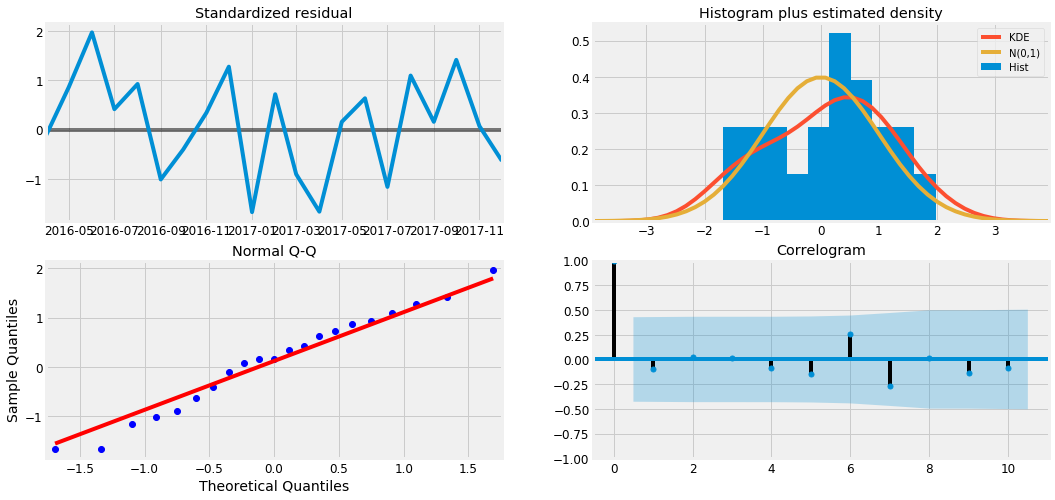

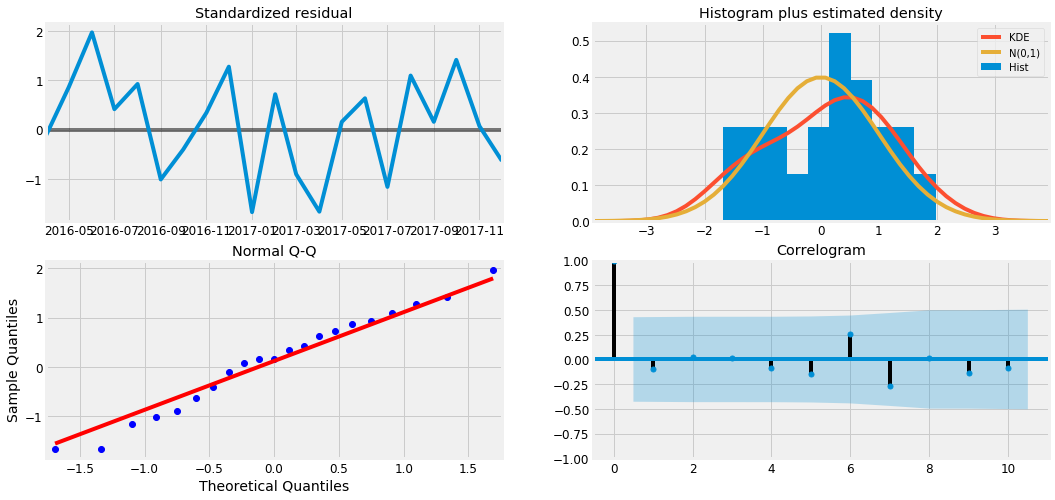

In [21]:
results.plot_diagnostics(figsize=(16, 8))

**Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.**

It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.

# Validating forecasts

We have obtained a model for our time series that can now be used to produce forecasts. **We start by comparing predicted values to real values of the time series,** which will help us understand the accuracy of our forecasts. 

The **get_prediction() and conf_int() attributes** allow us to obtain the values and associated confidence intervals for forecasts of the time series.

**And we set forecasts to start at 2017-01-01 to the end of the data**

The below code requires the forecasts to start at January 2017.

The **dynamic=False** argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

In [22]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'),dynamic = False)
pred_ci = pred.conf_int()


We can plot the real and forecasted values of the Furniture Sales time series to assess how well we did.

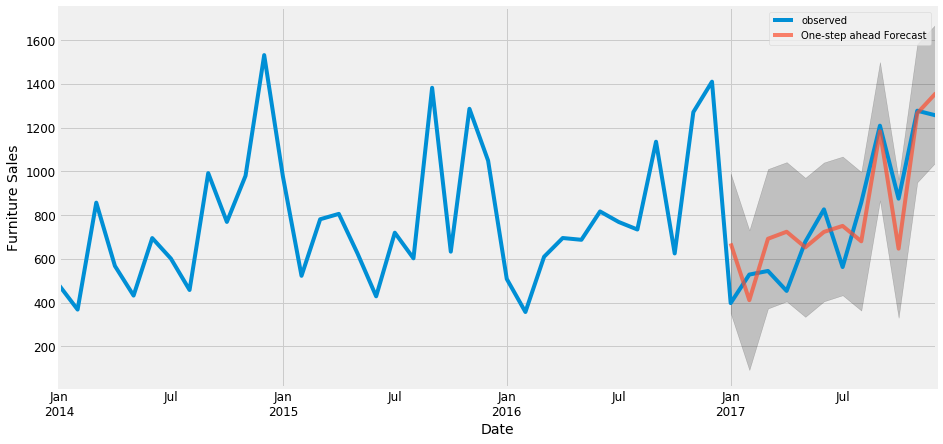

In [23]:
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label = 'One-step ahead Forecast',alpha=.7, figsize=(14,7))

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],color='k',alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, **showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.**

It is also useful to quantify the accuracy of our forecasts. **We will use the MSE (Mean Squared Error), which summarizes the average error of our forecasts.**

For each predicted value, we compute its distance to the true value and square the results. The results need to be sqaured so that positive/negative difference do not cancel each other out when we compute the overall mean.

In [24]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

mse = ((y_forecasted - y_truth)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 27090.48


In [25]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 164.59


In statistics, **the mean squared error (MSE)** of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.


**Root Mean Square Error (RMSE)** tells us that our model was able to forecast the average daily furniture sales in the test set within 164.59 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.

# Producing and visualizing forecasts

In the final step of this tutorial, we describe how to leverage our seasonal ARIMA time series model to forecast future values. The **get_forecast() attribute** of our time series object can compute forecasted values for a specified number of steps ahead.


In [26]:
# Get forecast 100 steps ahead in future
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

We can use the output of this code to plot the time series and forecasts of its future values.

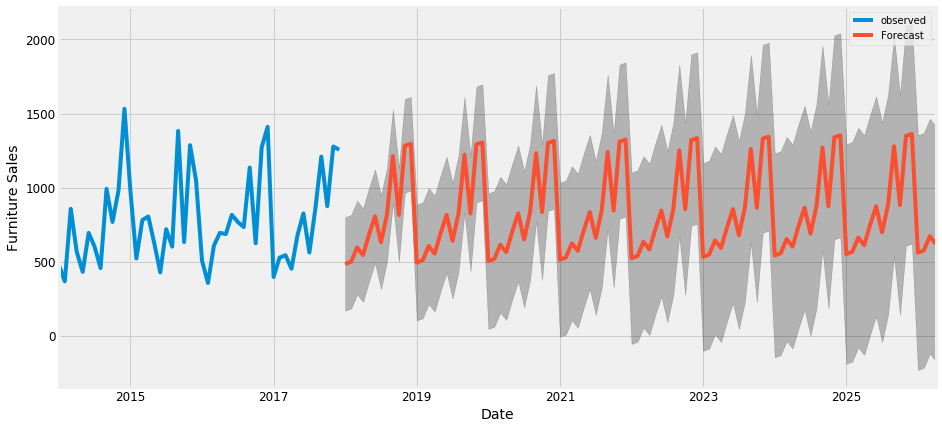

In [27]:
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

# Time Series of Furniture vs. Office Supplies

According to our data, there were way more number of sales from Office Supplies than from Furniture over the years.

In [28]:
furniture = df.loc[df['Category'] =='Furniture']
office = df.loc[df['Category'] =='Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

# Data Exploration

We are going to compare two categories’ sales in the same time period. This means combine two data frames into one and plot these two categories’ time series into one plot.

In [29]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']

In [30]:
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

In [31]:
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

In [32]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

In [33]:
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

In [35]:
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

In [36]:
furniture = pd.DataFrame({'Order Date':y_furniture.index,'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date':y_office.index,'Sales':y_office.values})

In [37]:
store = furniture.merge(office, how='inner',on='Order Date')

In [41]:
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y':'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


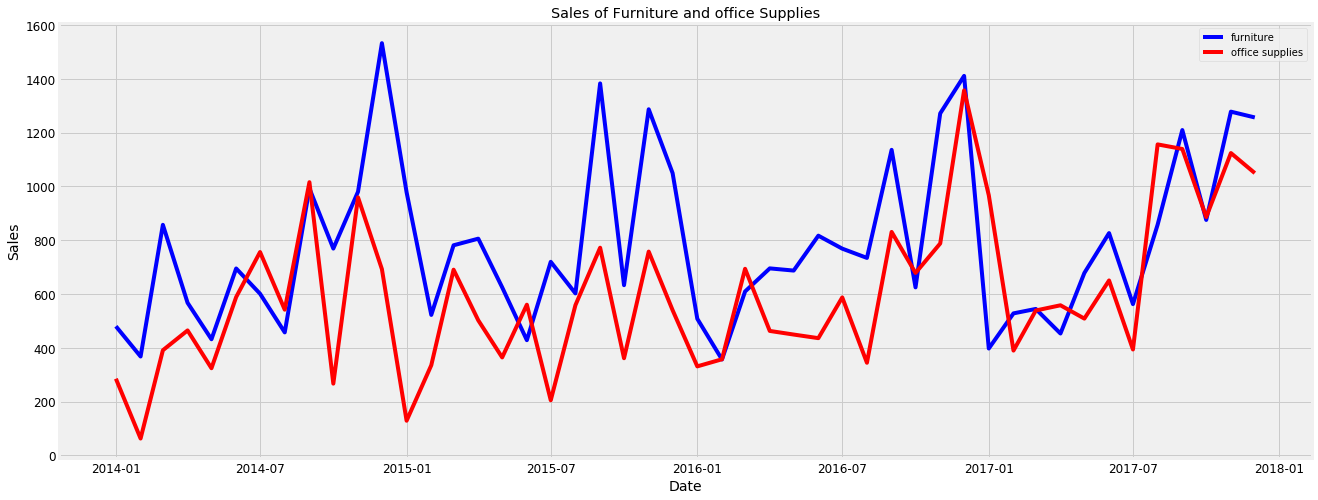

In [43]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'],'b-',label ='furniture')
plt.plot(store['Order Date'], store['office_sales'],'r-',label ='office supplies')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales of Furniture and office Supplies')
plt.legend()



We observe that sales of furniture and office supplies shared a similar seasonal pattern. Early of the year is the off season for both of the two categories. It seems summer time is quiet for office supplies too.

In addition, average daily sales for furniture are higher than those of office supplies in most of the months. It is understandable, as the value of furniture should be much higher than those of office supplies. **Occasionally, office supplies passed furniture on average daily sales. Let’s find out when was the first time office supplies’ sales surpassed those of furniture’s.**

In [46]:
first_date = store.loc[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']

print('office supplies first time produced higher sales than furniture is {}.'.format(first_date.date()))

office supplies first time produced higher sales than furniture is 2014-07-01.


# Time Series Modeling with Prophet

Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

In [51]:
from fbprophet import Prophet

In [53]:
furniture = furniture.rename(columns={'Order Date': 'ds','Sales':'y'})

furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date':'ds', 'Sales':'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [54]:
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

In [55]:
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

<Figure size 1296x432 with 0 Axes>

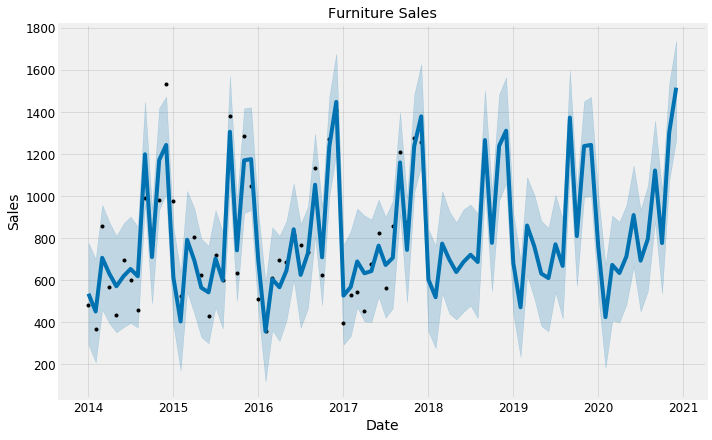

In [56]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 1296x432 with 0 Axes>

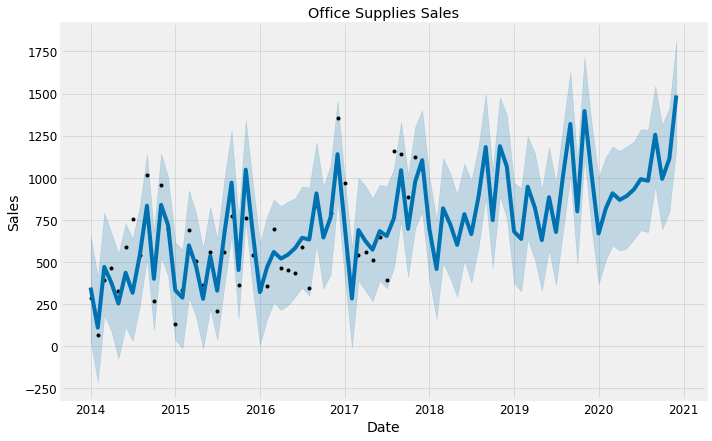

In [57]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

# Compare Forecasts

We already have the forecasts for three years for these two categories into the future. We will now join them together to compare their future forecasts.

In [58]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.057713,292.944033,776.946394,726.057713,726.057713,-190.685662,-190.685662,-190.685662,-190.685662,...,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,0.0,0.0,0.0,347.490278
1,2014-02-01,727.494023,209.164017,700.106294,727.494023,727.494023,-276.377703,-276.377703,-276.377703,-276.377703,...,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,0.0,0.0,0.0,109.240162
2,2014-03-01,728.791335,461.006831,958.071082,728.791335,728.791335,-22.389755,-22.389755,-22.389755,-22.389755,...,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,0.0,0.0,0.0,470.211349
3,2014-04-01,730.227645,394.548228,874.829765,730.227645,730.227645,-100.141158,-100.141158,-100.141158,-100.141158,...,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,0.0,0.0,0.0,374.687188
4,2014-05-01,731.617622,352.036197,810.486501,731.617622,731.617622,-160.815662,-160.815662,-160.815662,-160.815662,...,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,0.0,0.0,0.0,252.306682


# Trend and Forecast Visualization

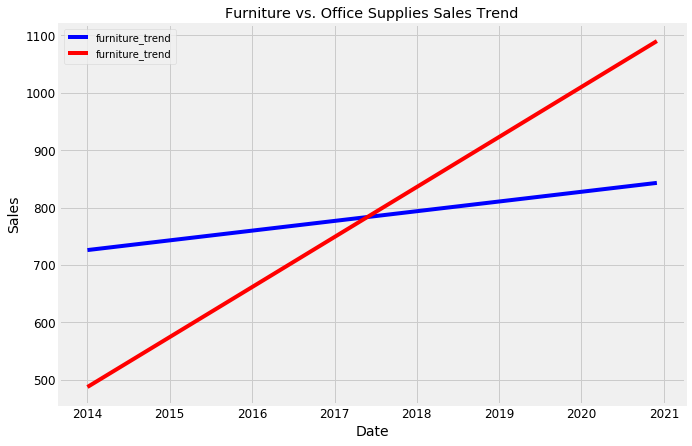

In [62]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-',label='furniture_trend')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-',label='furniture_trend')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

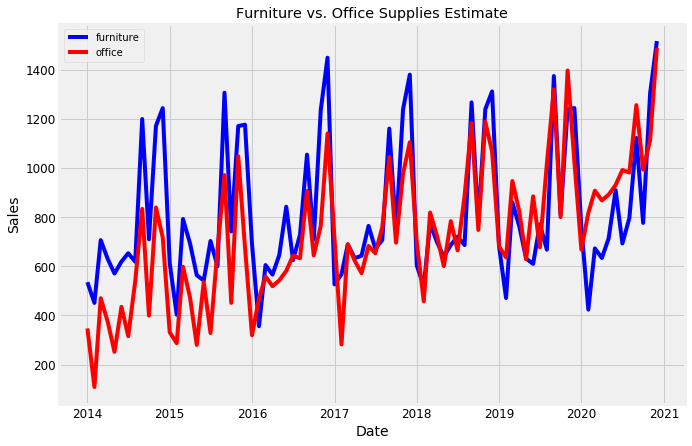

In [64]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-',label='furniture')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-',label='office')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

# Trends and Patterns

Now, we can use the Prophet Models to inspect different trends of these two categories in the data.

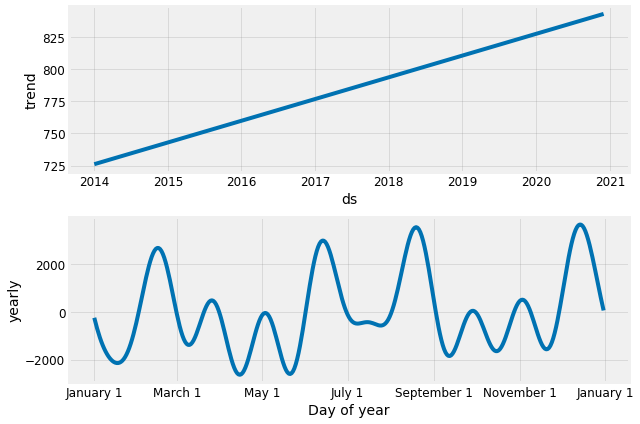

In [65]:
furniture_model.plot_components(furniture_forecast);

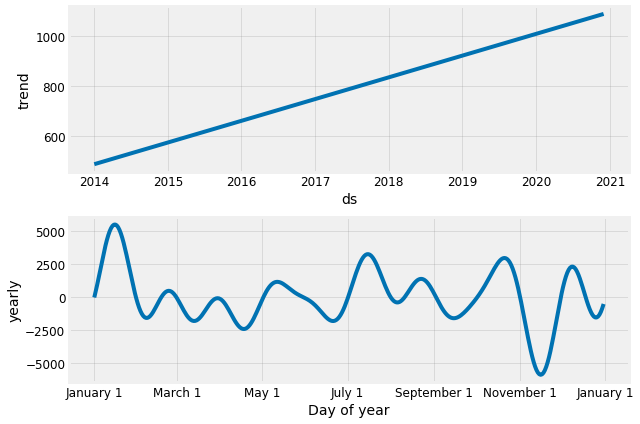

In [66]:
office_model.plot_components(office_forecast);

Good to see that the sales for both furniture and office supplies have been linearly increasing over time and will be keep growing, although office supplies’ growth seems slightly stronger.

**The worst month for furniture is April, the worst month for office supplies is February. The best month for furniture is December, and the best month for office supplies is October.**

There are many time-series analysis we can explore from now on, such as forecast with uncertainty bounds, change point and anomaly detection, forecast time-series with external data source. We have only just started.